In [1]:
#!/usr/bin/env python3
import os
import re
import sys
import collections
import argparse
import tables
import itertools
import matplotlib
import numba

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.sparse as sp_sparse

from multiprocessing import Pool
from collections import defaultdict
from scipy import sparse, io
from scipy.sparse import csr_matrix
from multiprocessing import Pool

np.random.seed(0)

In [2]:
WORK_DIR = '/project/GCRB/Hon_lab/s426305/Sequencing_data_analysis/10X/YW49-YW54_10x_mapping/nova_seq_data/sgRNA_lib_regex/'

## Combine all the df
___

In [3]:
YW61 = pd.read_pickle(WORK_DIR + 'YW61.sgRNA_adj_df.pkl')
YW62 = pd.read_pickle(WORK_DIR + 'YW62.sgRNA_adj_df.pkl')
YW63 = pd.read_pickle(WORK_DIR + 'YW63.sgRNA_adj_df.pkl')
YW64 = pd.read_pickle(WORK_DIR + 'YW64.sgRNA_adj_df.pkl')
YW65 = pd.read_pickle(WORK_DIR + 'YW65.sgRNA_adj_df.pkl')
YW66 = pd.read_pickle(WORK_DIR + 'YW66.sgRNA_adj_df.pkl')

In [4]:
sgRNA_df_adj_nova_regex = pd.concat([YW61, YW62, YW63, YW64, YW65, YW66], axis=1)

/home2/s426305/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [5]:
sgRNA_df_adj_nova_regex.shape

(20133, 77218)

In [6]:
sgRNA_df_adj_nova_regex

,GTAATGCTCCGAAATC-1,GTGTAACTCGGAGTAG-1,GGGAGTACACTCATAG-1,AGCCAATTCACTGATG-1,AGACCCGCAGCAGTGA-1,ACAGCCGGTAATTGGA-1,CCTCAGTGTCCTTGTC-1,ATTCTACTCCGAAGGA-1,ACGGTCGAGACCAGCA-1,CATTTCATCTTCCCAG-1,...,TCTATCAGTTGTCCCT-6,TCGCTTGCAGGTGGAT-6,AGCCAATAGCTCCACG-6,CACGGGTCAATGTGGG-6,CTTGAGATCTCGACGG-6,CAAGACTAGCGACAGT-6,TAGTGCATCTGCGGGT-6,GCTGAATTCGGCATAT-6,TTCTGTACAACCGGAA-6,AGTAGTCTCGTGGAAG-6
AAAAAAAACCCATCCCCCC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAAAAAATCTGTGATCAA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAAAAAATTCGGTTCTGC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAAAACCTCAGACAAGTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAAAACGCGACCTGGACA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTTTTAAGACAACAACAG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTTTTCAGCCTGTCCTCA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTTTTGGCCCAAATCTCG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTTTTTCATCCTCTGCCT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Keep the experimental singlets cell
____

In [8]:
singlet_ID = pd.read_pickle('/project/GCRB/Hon_lab/s426305/Sequencing_data_analysis/10X/YW49-YW54_10x_mapping/Remove_HTO_sub_df_nova.pkl').columns

In [9]:
len(singlet_ID)

57543

In [10]:
#Slice sgRNA df with experimental singlets
singlet_sgRNA_df = sgRNA_df_adj_nova_regex[singlet_ID]

In [11]:
singlet_sgRNA_df.shape

(20133, 57543)

## Calculate average number of guides per cell
___

In [12]:
def get_sgrna_per_cell(df, return_mean=True, return_median=True):
    CorrSgrnaPerCell = np.sum(df > 0, 0)
    sgrna_mean = np.mean(CorrSgrnaPerCell)
    sgrna_median = np.median(CorrSgrnaPerCell)
    print("Average sgRNA Number per Cell is: " + str(sgrna_mean))
    
    if return_mean & return_median:
        return CorrSgrnaPerCell, sgrna_mean, sgrna_median
    elif return_mean:
        return CorrSgrnaPerCell, sgrna_mean
    elif return_median:
        return CorrSgrnaPerCell, sgrna_median
    else:
        return CorrSgrnaPerCell

In [13]:
CorrSgrnaPerCell_regex, sgrna_mean_regex , sgrna_median_regex = get_sgrna_per_cell(singlet_sgRNA_df, return_mean=True, return_median=True)

Average sgRNA Number per Cell is: 34.25851971569087


In [14]:
CorrSgrnaPerCell_regex

AAACCCAAGCATCGAG-1    48
AAACCCAAGCCTCAGC-1     2
AAACCCAAGCGTGCCT-1    12
AAACCCAAGGAACGAA-1     0
AAACCCACACCAATTG-1     1
                      ..
TTTGTTGAGGTCATTC-6     5
TTTGTTGAGTGAGTTA-6    29
TTTGTTGCATTGAAGA-6    41
TTTGTTGGTCTTCCGT-6    21
TTTGTTGTCCTCTAGC-6    37
Length: 57543, dtype: int64

In [15]:
CorrSgrnaPerCell_regex[np.argwhere(CorrSgrnaPerCell_regex.values > 0)]

array([[48],
       [ 2],
       [12],
       ...,
       [41],
       [21],
       [37]])

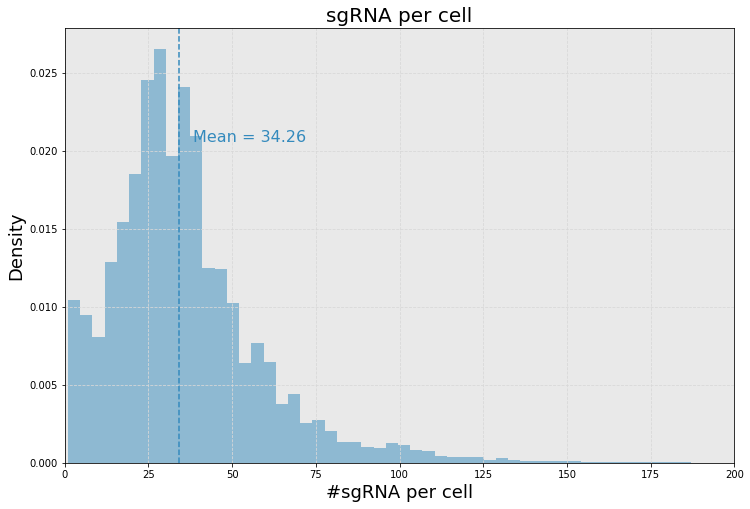

In [16]:
color_map = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

fig, ax = plt.subplots(figsize= (12,8))
ax.grid(ls='--', color='#D8D8D8')
ax.set_xlim(0,200)

ax.hist(CorrSgrnaPerCell_regex[np.argwhere(CorrSgrnaPerCell_regex.values > 0)], 
        color=color_map[0],
        bins=500, 
        density=True, 
        alpha=.5)


ax.axvline(sgrna_mean_regex, 
           ls='--', 
           color=color_map[0])

xmin = 0
xmax = 200
ymin, ymax = ax.get_ylim()
x_offset = (xmax - xmin) * 0.02
y_offset = (ymax - ymin) * 0.02

ax.text((sgrna_mean_regex + x_offset), 
        (0.02 + y_offset), 
        "Mean = " + str(np.round(sgrna_mean_regex, decimals=2)), 
        color=color_map[0], 
        fontsize=16)



ax.set_facecolor('#E9E9E9')
ax.set_ylabel('Density', fontsize=18)
ax.set_xlabel('#sgRNA per cell', fontsize=18)
ax.set_title("sgRNA per cell", fontsize=20)
plt.show()

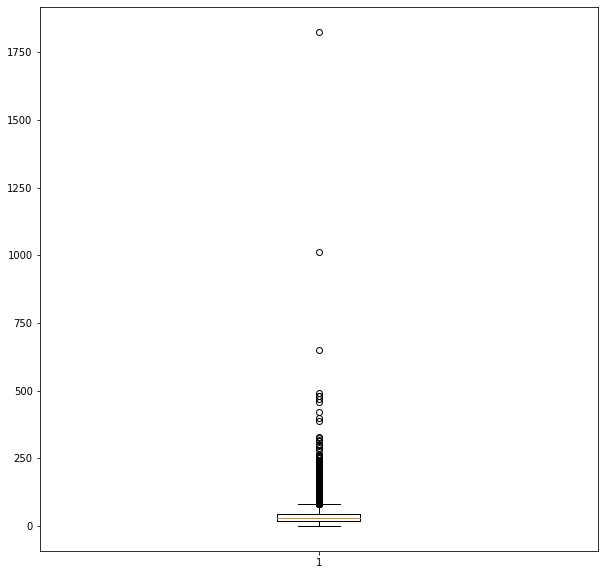

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
ax = plt.boxplot(CorrSgrnaPerCell_regex)
plt.show()

## Remove sgRNA outliers
___

In [18]:
Q1 = CorrSgrnaPerCell_regex.quantile(0.25)
Q3 = CorrSgrnaPerCell_regex.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

24.0


In [19]:
((CorrSgrnaPerCell_regex < (Q1 - 1.5 * IQR)) |(CorrSgrnaPerCell_regex > (Q3 + 1.5 * IQR)))

AAACCCAAGCATCGAG-1    False
AAACCCAAGCCTCAGC-1    False
AAACCCAAGCGTGCCT-1    False
AAACCCAAGGAACGAA-1    False
AAACCCACACCAATTG-1    False
                      ...  
TTTGTTGAGGTCATTC-6    False
TTTGTTGAGTGAGTTA-6    False
TTTGTTGCATTGAAGA-6    False
TTTGTTGGTCTTCCGT-6    False
TTTGTTGTCCTCTAGC-6    False
Length: 57543, dtype: bool

In [21]:
sgrna_df_out = singlet_sgRNA_df.loc[:,((CorrSgrnaPerCell_regex < (Q1 - 1.5 * IQR)) |(CorrSgrnaPerCell_regex > (Q3 + 1.5 * IQR))).values == False]
sgrna_df_out.shape

(20133, 55039)

In [22]:
CorrSgrnaPerCell_out, sgrna_mean_out , sgrna_median_out = get_sgrna_per_cell(sgrna_df_out, return_mean=True, return_median=True)

Average sgRNA Number per Cell is: 30.877305183597084


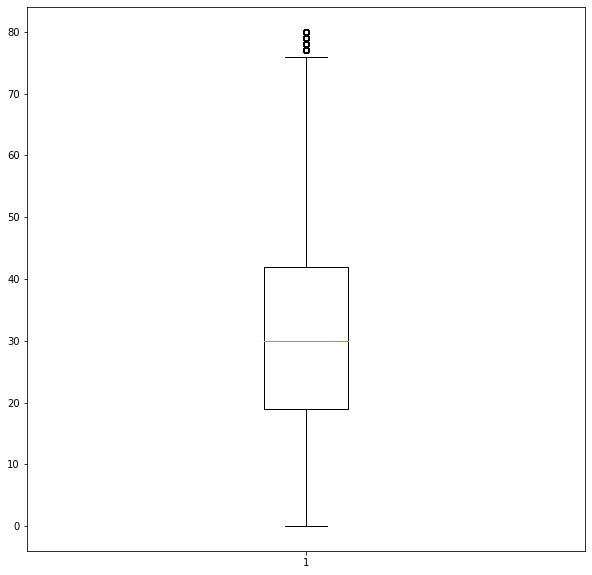

In [23]:
fig, ax = plt.subplots(figsize=(10,10))
ax = plt.boxplot(CorrSgrnaPerCell_out)
plt.show()

## Save as pickle file 
___

In [24]:
sgrna_df_out

,AAACCCAAGCATCGAG-1,AAACCCAAGCCTCAGC-1,AAACCCAAGCGTGCCT-1,AAACCCAAGGAACGAA-1,AAACCCACACCAATTG-1,AAACCCACACGGGCTT-1,AAACCCACAGAGATGC-1,AAACCCACAGGTCCGT-1,AAACCCAGTAGCTTAC-1,AAACCCAGTGACAGGT-1,...,TTTGGAGCAGCCTATA-6,TTTGGAGCAGGTCAAG-6,TTTGGTTGTAACTTCG-6,TTTGGTTGTAATCAAG-6,TTTGGTTGTCTATGAC-6,TTTGTTGAGGTCATTC-6,TTTGTTGAGTGAGTTA-6,TTTGTTGCATTGAAGA-6,TTTGTTGGTCTTCCGT-6,TTTGTTGTCCTCTAGC-6
AAAAAAAACCCATCCCCCC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAAAAAATCTGTGATCAA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAAAAAATTCGGTTCTGC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAAAACCTCAGACAAGTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAAAACGCGACCTGGACA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTTTTAAGACAACAACAG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTTTTCAGCCTGTCCTCA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTTTTGGCCCAAATCTCG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTTTTTCATCCTCTGCCT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
sgrna_df_out.to_pickle('/project/GCRB/Hon_lab/s426305/Sequencing_data_analysis/10X/YW49-YW54_10x_mapping/nova_seq_data/sgRNA_df_adj_regex.pkl')